# Lab4-Assignment about Named Entity Recognition and Classification

This notebook describes the assignment of Lab 4 of the text mining course. We assume you have succesfully completed Lab1, Lab2 and Lab3 as welll. Especially Lab2 is important for completing this assignment.

**Learning goals**
* going from linguistic input format to representing it in a feature space
* working with pretrained word embeddings
* train a supervised classifier (SVM)
* evaluate a supervised classifier (SVM)
* learn how to interpret the system output and the evaluation results
* be able to propose future improvements based on the observed results


## Credits
This notebook was originally created by [Marten Postma](https://martenpostma.github.io) and [Filip Ilievski](http://ilievski.nl) and adapted by Piek vossen

## [Points: 18] Exercise 1 (NERC): Training and evaluating an SVM using CoNLL-2003

**[4 point] a) Load the CoNLL-2003 training data using the *ConllCorpusReader* and create for both *train.txt* and *test.txt*:**

    [2 points]  -a list of dictionaries representing the features for each training instances, e..g,
    ```
    [
    {'words': 'EU', 'pos': 'NNP'}, 
    {'words': 'rejects', 'pos': 'VBZ'},
    ...
    ]
    ```

    [2 points] -the NERC labels associated with each training instance, e.g.,
    dictionaries, e.g.,
    ```
    [
    'B-ORG', 
    'O',
    ....
    ]
    ```

**Text answer to exercise 1 (a):**

The cells below load the CoNLL-2003 data into training and test data. The list of features we chose for this data are: the tokenised word, POS tag, 3-letter and 2-letter suffix, whether the first letter is capitalised, and whether the word is a title. The instances in each test are represented as dictionaries of the words and their features. These dictionaries are saved in a list of dictionaries labelled 'features'. The NERC tags are loaded as a list of labels called golf_labels.

In [16]:
from nltk.corpus.reader import ConllCorpusReader
### Adapt the path to point to the CONLL2003 folder on your local machine
train = ConllCorpusReader('./CONLL2003', 'train.txt', ['words', 'pos', 'ignore', 'chunk'])
training_features = []
training_gold_labels = []

for token, pos, ne_label in train.iob_words():
   a_dict = {
      'word': token,                # the word itself
      'pos': pos,                   # the part of speech
      'word[-3:]': token[-3:],      # the last three characters of the word
      'word[-2:]': token[-2:],      # the last two characters of the word
      'upper': token[0].isupper(),  # whether the first letter is uppercase
      'title': token.istitle(),      # whether the word is titlecased 
                                 
         # NOTE: 'upper' and 'lower' will be slightly different because
         # of words like 'EU' being uppercased but not titlecased

   }

   training_features.append(a_dict)
   training_gold_labels.append(ne_label)
   

In [17]:
### Adapt the path to point to the CONLL2003 folder on your local machine
test = ConllCorpusReader('./CONLL2003', 'test.txt', ['words', 'pos', 'ignore', 'chunk'])

test_features = []
test_gold_labels = []
for token, pos, ne_label in test.iob_words():
    a_dict = {
        'word': token,                # the word itself
        'pos': pos,                   # the part of speech
        'word[-3:]': token[-3:],      # the last three characters of the word
        'word[-2:]': token[-2:],      # the last two characters of the word
        'upper': token[0].isupper(),  # whether the first letter is uppercase
        'title': token.istitle(),      # whether the word is titlecased 
                                 
        # NOTE: 'upper' and 'lower' will be slightly different because
        # of words like 'EU' being uppercased but not titlecased

    }

    test_features.append(a_dict)
    test_gold_labels.append(ne_label)

**[2 points] b) provide descriptive statistics about the training and test data:**
* How many instances are in train and test?
* Provide a frequency distribution of the NERC labels, i.e., how many times does each NERC label occur?
* Discuss to what extent the training and test data is balanced (equal amount of instances for each NERC label) and to what extent the training and test data differ?

Tip: you can use the following `Counter` functionality to generate frequency list of a list:

**Text answer to exercise 1 (b)**

The training set has 203621 instances and the test set has 46435 instances. The frequency distribution of the NERC labels can be seen in the bar plot below followed by the exact percentage of the data that each label represents. The graph shows that the labels decrease in frequency at a fairly constant rate, and the test and training sets have very similar distributions.

In [18]:
print(f"Training set size:  {len(training_features)}     = number of labels?: {len(training_features)==len(training_gold_labels)}")
print(f"    Test set size:  {len(test_features)}      = number of labels?: {len(test_features)==len(test_gold_labels)}")

Training set size:  203621     = number of labels?: True
    Test set size:  46435      = number of labels?: True


In [19]:
from collections import Counter 
print("Training set NERC label counts:")
Counter(training_gold_labels)

Training set NERC label counts:


Counter({'O': 169578,
         'B-LOC': 7140,
         'B-PER': 6600,
         'B-ORG': 6321,
         'I-PER': 4528,
         'I-ORG': 3704,
         'B-MISC': 3438,
         'I-LOC': 1157,
         'I-MISC': 1155})

In [20]:
print("Test set NERC label counts:")
Counter(test_gold_labels)

Test set NERC label counts:


Counter({'O': 38323,
         'B-LOC': 1668,
         'B-ORG': 1661,
         'B-PER': 1617,
         'I-PER': 1156,
         'I-ORG': 835,
         'B-MISC': 702,
         'I-LOC': 257,
         'I-MISC': 216})

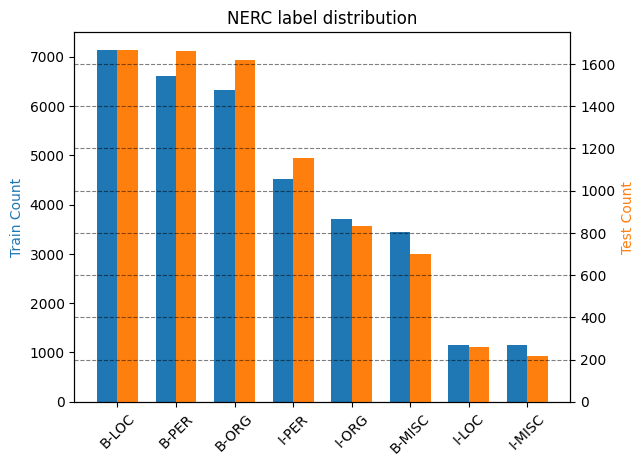

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# create counts
train_ne_label_counts = Counter(training_gold_labels)
test_ne_label_counts = Counter(test_gold_labels)

# COMMENT THIS TO INCLUDE 'O' LABEL ––––––––––––––––––––––––––!!!!!!!!!!!!!!
train_ne_label_counts.pop('O')
test_ne_label_counts.pop('O')
# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––!!!!!!!!!!!!!!

# sort by count
train_ne_label_counts = dict(sorted(train_ne_label_counts.items(), key=lambda item: item[1], reverse=True))
test_ne_label_counts = dict(sorted(test_ne_label_counts.items(), key=lambda item: item[1], reverse=True))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
bar_width = 0.35
train_x = np.arange(len(train_ne_label_counts))
test_x = train_x + bar_width
ax1.bar(train_x, train_ne_label_counts.values(), width=bar_width, color='tab:blue', label='Train Count')
ax1.set_ylabel('Train Count', color='tab:blue')
ax2.bar(test_x, test_ne_label_counts.values(), width=bar_width, color='tab:orange', label='Test Count')
ax2.set_ylabel('Test Count', color='tab:orange')
ax1.set_xticks(train_x + bar_width / 2)
ax1.set_xticklabels(train_ne_label_counts.keys(), rotation=45)
plt.title("NERC label distribution")
plt.grid(True, color='black', linestyle='--', alpha=0.5)
plt.show()


In [22]:
def label_distribution(data):
    a_dict = {}
    for label in Counter(data):
        a_dict[label] = Counter(data)[label]/len(data)*100
    return a_dict

print("Training set NERC label distribution:\n")

training_dist = label_distribution(training_gold_labels)
training_dist = dict(sorted(training_dist.items(), key=lambda item: item[1], reverse=True))
test_dist = label_distribution(test_gold_labels)
for label in training_dist:
    print(f"{label}: {training_dist[label]:.2f}% | {test_dist[label]:.2f}% ––––– difference: {training_dist[label]-test_dist[label]:.2f}%")

Training set NERC label distribution:

O: 83.28% | 82.53% ––––– difference: 0.75%
B-LOC: 3.51% | 3.59% ––––– difference: -0.09%
B-PER: 3.24% | 3.48% ––––– difference: -0.24%
B-ORG: 3.10% | 3.58% ––––– difference: -0.47%
I-PER: 2.22% | 2.49% ––––– difference: -0.27%
I-ORG: 1.82% | 1.80% ––––– difference: 0.02%
B-MISC: 1.69% | 1.51% ––––– difference: 0.18%
I-LOC: 0.57% | 0.55% ––––– difference: 0.01%
I-MISC: 0.57% | 0.47% ––––– difference: 0.10%


**[2 points] c) Concatenate the train and test features (the list of dictionaries) into one list. Load it using the *DictVectorizer*. Afterwards, split it back to training and test.**

Tip: You’ve concatenated train and test into one list and then you’ve applied the DictVectorizer.
The order of the rows is maintained. You can hence use an index (number of training instances) to split the_array back into train and test. Do NOT use: `
from sklearn.model_selection import train_test_split` here.


In [23]:
all_features = training_features.copy()
all_features.extend(test_features)

In [24]:
from sklearn.feature_extraction import DictVectorizer

In [25]:
vec = DictVectorizer()
the_array = vec.fit_transform(all_features)
# print(the_array.shape)

vec_training_features = the_array[:len(training_features)]
vec_test_features = the_array[len(training_features):]

# print(len(vec_training_features.toarray()))
# print(len(vec_test_features.toarray()))


In [26]:
all_features = training_features.copy()
all_features.extend(test_features)

vec = DictVectorizer()
the_array = vec.fit_transform(all_features)
# print(the_array.shape)

vec_training_features = the_array[:len(training_features)]
vec_test_features = the_array[len(training_features):]

# print(len(vec_training_features.toarray()))
# print(len(vec_test_features.toarray()))

**[4 points] d) Train the SVM using the train features and labels and evaluate on the test data. Provide a classification report (sklearn.metrics.classification_report).**
The train (*lin_clf.fit*) might take a while. On my computer, it took 1min 53s, which is acceptable. Training models normally takes much longer. If it takes more than 5 minutes, you can use a subset for training. Describe the results:
* Which NERC labels does the classifier perform well on? Why do you think this is the case?
* Which NERC labels does the classifier perform poorly on? Why do you think this is the case?

**Text answer to exercise 1 (d):**
- The classifier performs well on B-LOC, B-MISC and really well on O. B-LOC is the first token in an entity that is a location. We think this performs well because it is the most prevalent label outside of the O label, which makes it easier to guess. B-MISC is the first token in an entity where the tokens are name enties that are not in one of the other categories. We think this performs well because it usually has a recognizable pattern, with the first letter being capitalized, and the last 3 letters often being 'ian' or 'ean' to note someone of a certain descent. The last 3 letters of the word is one of the features. Lastly O is used for tokens that are oustide of named entites. This performs really well because it is very prevalent, and most of the words are uncapitalized.
- The classifier performs poorly on I-ORG and I-per. I-ORG denotes tokens inside an organization entity. We think this could be because understanding an token inside an organization entity may require understanding of the context. I-PER represents tokens inisde a person entity. We think this is also because context can play a big role in this. As well as the variability of ways a person can be denoted. This diversity makes it more difficult for the classifier. 

In [27]:
from sklearn import svm

In [28]:
lin_clf = svm.LinearSVC()

In [29]:
from sklearn.metrics import classification_report

# Train the SVM model
lin_clf.fit(vec_training_features, training_gold_labels)
predicted_labels = lin_clf.predict(vec_test_features)

report = classification_report(test_gold_labels, predicted_labels)

print(report)


c:\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


KeyboardInterrupt: 

**[6 points] e) Train a model that uses the embeddings of these words as inputs. Test again on the same data as in 2d. Generate a classification report and compare the results with the classifier you built in 2d.**

**Text answer to exercise 1 (e):**

We see that the performance for B-org and B-per increase significantly. This could very well be because word embeddings allow for that little bit of context needed to recognize these words.

However, we also see a decrease in performance for I-loc and I-org. This could be explained by the fact that words that are often used in the inside of such expressions can also be used as just a normal word (for example, Dominican republic is a location, however, the word republic seperately is not a named entity and will thus be labeled as O). This also explain the drop (although slight) in performance for O. 

The same does not go for I-per, since names are usually not used in a different context and thus will still be recognized as names.

In [33]:
from pathlib import Path
cur_dir = Path().resolve() # this should provide you with the folder in which this notebook is placed
path_to_file = Path.joinpath(cur_dir, 'GoogleNews-vectors-negative300.bin')
print(path_to_file)
print('does path exist? ->', Path.exists(path_to_file))

C:\Users\Yari\OneDrive - Vrije Universiteit Amsterdam\Year 3\Period 3.4\Text mining\ba-text-mining-group19\lab_sessions\lab4\GoogleNews-vectors-negative300.bin
does path exist? -> False


In [35]:
import gensim

word_embedding_model = gensim.models.KeyedVectors.load_word2vec_format(path_to_file, binary=True)  

input_vectors=[]
labels=[]
for token, pos, ne_label in train.iob_words():
    
    if token!='' and token!='DOCSTART':
        if token in word_embedding_model:
            vector=word_embedding_model[token]
        else:
            vector=[0]*300
        input_vectors.append(vector)
        labels.append(ne_label)

In [36]:
test_input_vectors = []
test_labels = []

for token, pos, ne_label in test.iob_words():
    if token != '' and token != 'DOCSTART':
        if token in word_embedding_model:
            vector = word_embedding_model[token]
        else:
            vector = [0] * 300
        test_input_vectors.append(vector)
        test_labels.append(ne_label)

In [23]:
from sklearn import svm

lin_clf = svm.LinearSVC()


In [24]:
lin_clf.fit(input_vectors, labels)
predicted_labels = lin_clf.predict(test_input_vectors)

report = classification_report(test_labels, predicted_labels)

print(report)

c:\Users\Isate\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

       B-LOC       0.76      0.80      0.78      1668
      B-MISC       0.72      0.70      0.71       702
       B-ORG       0.69      0.64      0.66      1661
       B-PER       0.75      0.67      0.71      1617
       I-LOC       0.51      0.42      0.46       257
      I-MISC       0.60      0.54      0.57       216
       I-ORG       0.48      0.33      0.39       835
       I-PER       0.59      0.50      0.54      1156
           O       0.97      0.99      0.98     38323

    accuracy                           0.93     46435
   macro avg       0.68      0.62      0.64     46435
weighted avg       0.92      0.93      0.92     46435



## [Points: 10] Exercise 2 (NERC): feature inspection using the [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)
**[6 points] a. Perform the same steps as in the previous exercise. Make sure you end up for both the training part (*df_train*) and the test part (*df_test*) with:**
* the features representation using **DictVectorizer**
* the NERC labels in a list

Please note that this is the same setup as in the previous exercise:
* load both train and test using:
    * list of dictionaries for features
    * list of NERC labels
* combine train and test features in a list and represent them using one hot encoding
* train using the training features and NERC labels

In [22]:
import pandas

In [23]:
##### Adapt the path to point to your local copy of NERC_datasets
path = '/Users/axelehrnrooth/Desktop/Text Mining/other/nerc_datasets/kaggle/ner_v2.csv'
kaggle_dataset = pandas.read_csv(path, on_bad_lines='warn')

/var/folders/12/wd9t8m850v12fpd_v81hh2hm0000gn/T/ipykernel_87785/13394443.py:3: ParserWarning: Skipping line 281837: expected 25 fields, saw 34

  kaggle_dataset = pandas.read_csv(path, on_bad_lines='warn')


In [24]:
len(kaggle_dataset)

1050795

In [25]:
df_train = kaggle_dataset[:100000]
df_test = kaggle_dataset[100000:120000]
print(len(df_train), len(df_test))

100000 20000


In [80]:
df_train.head(20)

,id,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
5,5,through,london,to,TO,lowercase,to,NNP,capitalized,London,...,have,VBP,lowercase,have,lowercase,marched,1.0,lowercase,through,O
6,6,london,to,protest,VB,lowercase,protest,TO,lowercase,to,...,march,VBN,lowercase,marched,lowercase,through,1.0,capitalized,London,B-geo
7,7,to,protest,the,DT,lowercase,the,VB,lowercase,protest,...,through,IN,lowercase,through,capitalized,London,1.0,lowercase,to,O
8,8,protest,the,war,NN,lowercase,war,DT,lowercase,the,...,london,NNP,capitalized,London,lowercase,to,1.0,lowercase,protest,O
9,9,the,war,in,IN,lowercase,in,NN,lowercase,war,...,to,TO,lowercase,to,lowercase,protest,1.0,lowercase,the,O


In [27]:
print(df_train.columns)


Index(['id', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')


In [87]:
# TRAINING SET
training_features = []
training_gold_labels = []

columns_to_exclude = ['id', 'tag', 'next-next-lemma', 'next-next-pos', 'next-next-shape', 'next-next-word', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape', 'prev-prev-word', 'sentence_idx',]
training_gold_labels = df_train['tag'].tolist()
columns = [x for x in df_train.columns if x not in columns_to_exclude]

training_features = df_train[columns].to_dict('records')

# TEST SET 
test_features = []
test_gold_labels = []

columns_to_exclude = ['tag']
test_gold_labels = df_test['tag'].tolist()
columns = [x for x in df_test.columns if x not in columns_to_exclude]

test_features = df_test[columns].to_dict('records')


In [88]:
# DICT VECTORIZER

all_features = training_features.copy()
all_features.extend(test_features)

vec = DictVectorizer()
the_array = vec.fit_transform(all_features)
# print(the_array.shape)

vec_training_features = the_array[:len(training_features)]
vec_test_features = the_array[len(training_features):]

# print(len(vec_training_features.toarray()))
# print(len(vec_test_features.toarray()))

**[4 points] b. Train and evaluate the model and provide the classification report:**
* use the SVM to predict NERC labels on the test data
* evaluate the performance of the SVM on the test data

Analyze the performance per NERC label.

**Text answer to exercise 2 (b):**

For B-art and I-art, we can see that there are very little to no instances, leading to very low scores overall (in fact, the F1 score is 0 for these). The same goes for B-eve, this one also having no instances in the training data.

We can see that all of B-geo, B-gpe, B-tim, I-geo, I-gpe, I-nat, I-org, I- tim and finally '0' perform above 80% in the F1-score column. We also see that generally, the I part of each label outperforms its B-counterpart. This makes sense, since a NE that has more than one word to it, is easier to distinguish as they have more information to give, whereas a singular word could have no information in its context.

Furthermore, we see that specifically B-nat, B-per and B-org underperform, having an F1-score of lower than 81% (77, 80 and 71 percent respectively). We also see a large disparity between the B and I counterparts here. This could very well be due to the fact that when used as a singular word, a lot of information is lost (if you knew nothing about the Missisipi, it would be easier to recognize it as a natural phenomenon if it  was called 'the Missisipi River' rather than 'the Missisipi'. River gives a lot of information here, but the latter example could also be used in a text). We think that the lower performance could be due to the fact that to a computer, these words all look alike -> Missisipi could very well be a name of a person, and Olivia could very well be the name of some organization. Thus, a lot of context is needed to guess these words, which the model in this case does not have (only the words directly around the instance it is labeling).

Finally, we have the '0'  label. Most of the data consists of these words. Thus, the model has a lot of information on these words and can accurately guess them.



In [89]:
lin_clf = svm.LinearSVC()

# Train the SVM model
lin_clf.fit(vec_training_features, training_gold_labels)
predicted_labels = lin_clf.predict(vec_test_features)

report = classification_report(test_gold_labels, predicted_labels)

print(report)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         4
       B-eve       0.00      0.00      0.00         0
       B-geo       0.87      0.87      0.87       741
       B-gpe       0.90      0.94      0.92       296
       B-nat       1.00      0.62      0.77         8
       B-org       0.75      0.67      0.71       397
       B-per       0.81      0.80      0.80       333
       B-tim       0.95      0.84      0.89       393
       I-art       0.00      0.00      0.00         0
       I-geo       0.97      0.98      0.98       156
       I-gpe       1.00      1.00      1.00         2
       I-nat       1.00      1.00      1.00         4
       I-org       0.95      0.94      0.94       321
       I-per       0.96      0.98      0.97       319
       I-tim       0.93      0.85      0.89       108
           O       0.99      0.99      0.99     16918

    accuracy                           0.97     20000
   macro avg       0.75   

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## End of this notebook